In [280]:
%matplotlib inline

import os
import json

import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy import ndimage
import skimage
import scipy.stats
import scipy
from pprint import pprint
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mutual_info_score

In [313]:
global_scaling = 4

def load_images(path, name):
    """
        Loads original, thermal and visible image from dataset
    """
    original = cv2.imread(os.path.join(path, name)) / 255
    thermal = cv2.imread(os.path.join(path, "extracted/thermal", name)) / 255
    visible = cv2.imread(os.path.join(path, "extracted/visible", name)) / 255
    return original, thermal, visible

def load_prepare(path, name):
    """
        Loads images, scales VIS and FIR to shape and collapses to 1 channel
    """
    orig, thr, vis = load_images(path, name)
    
    # Compress into single channel
    thr = np.mean(thr, 2)
#     vis = np.mean(vis, 2)
#     print(vis.shape)
    
    vis = skimage.color.rgb2lab(vis)[..., 0]

    # Align shapes
#     vis = cv2.resize(vis, (120, 160))
#     thr = cv2.resize(thr, (120, 160))
    vis = cv2.resize(vis, (thr.shape[1]//global_scaling, thr.shape[0]//global_scaling))
    thr = cv2.resize(thr, (thr.shape[1]//global_scaling, thr.shape[0]//global_scaling))
    return orig, thr, vis


def load_complete(path, name):
    """
        Loads images, scales VIS and FIR to shape and collapses to 1 channel
    """
    orig, thr, vis = load_images(path, name)
    
    # Compress into single channel
    thr = np.mean(thr, 2)

    # Align shapes
    vis = cv2.resize(vis, (thr.shape[1]//global_scaling, thr.shape[0]//global_scaling))
    thr = cv2.resize(thr, (thr.shape[1]//global_scaling, thr.shape[0]//global_scaling))
    return orig, thr, vis

def superimpose(a, b):
    """
        Superimposes 2 images
    """
    return np.mean(np.dstack([a, b]), axis=2)

def show_old(img, ax, title, neg=True):
    """
        Displays an image.
        Uses negative by default for better visibility.
    """
    ax.imshow(1-img if neg else img)
    ax.set_title(title)
    ax.axis("off")

def show(img):
    plt.figure(figsize=(10,10))
    plt.imshow(img)

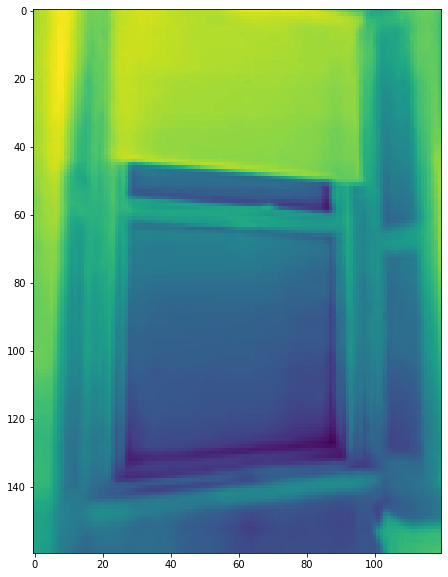

In [363]:
root_path = "../../data/calibration_rotation"
# root_path = "../../data/calibration"
with open(os.path.join(root_path, "metadata.json")) as f:
    metadata = json.load(f)

orig, fir, rgb = load_prepare(root_path, list(metadata["photos"].keys())[0])

plt.figure(figsize=(10, 10))
plt.imshow(fir)

In [358]:
# Law's filters

def convolve_law(img, f_names):
    filters = {
        "L": np.array([[1, 4, 6, 4, 1]]),
        "E": np.array([[-1, -2, 0, 2, 1]]),
        "S": np.array([[-1, 0, 2, 0, -1]]),
        "R": np.array([[1, -4, 6, -4, 1]]),
    }

    col_conv, row_conv = filters[f_names[0]].T, filters[f_names[1]]
    
    conv_img = ndimage.convolve(img, col_conv)
    conv_img = ndimage.convolve(conv_img, row_conv)
    return conv_img

def to_texture_energy(img):
    kernel = np.ones(shape=(15,15))
    energy_img = np.abs(img)
    energy_img = ndimage.convolve(energy_img, kernel)
    return energy_img
    

def threshold(img):
    mean = np.mean(img)
    std = np.std(img)
    thresholded_img = np.where(np.abs(img) <= 3*std, img, 0)
    return thresholded_img


def quantize(img):
    img_ = img / img.max() * 255
    return img_

def preprocess(img, filters):
    img_ = convolve_law(img, filters)
    img_ = to_texture_energy(img_)
    img_ = threshold(img_)
    img_ = quantize(img_)
    return img_
    

# plt.imshow(convolve_law(rgb, "EL"))

0.0

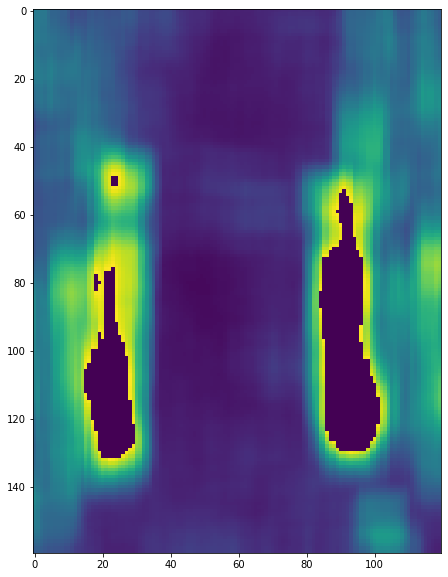

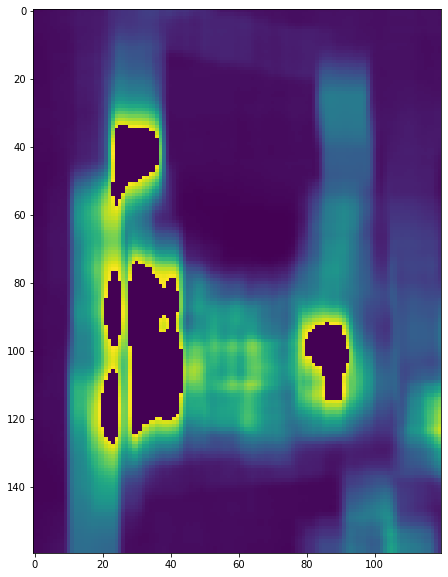

In [359]:

fir_a = preprocess(fir, "LR")
rgb_a = preprocess(rgb, "LR")

show(fir_a)
show(rgb_a)

rgb_a.min()

In [392]:
trans = np.array([
    [ 1.22625812e+00, -1.21753247e-03, -1.60819805e+01],
    [-2.71915584e-02,  1.20373377e+00, -1.66152597e+01],
])

rgb_trans = cv2.warpAffine(rgb_a, trans, (fir_a.shape[1], fir_a.shape[0]))
mutual_info_score(rgb_trans.flatten(), fir_a.flatten())
mutual_information(rgb_trans, fir_a)


# fig, (ax1, ax2) = plt.subplots(1, 2)
# ax1.imshow(abs(fir_laplacian))
# ax2.imshow(abs(rgb_trans))

9.920886285250747

In [378]:
def test(fir, rgb, debug=False):
    
    rgb_trans = cv2.warpAffine(rgb, trans, (fir.shape[1], fir.shape[0]))
    
    features = "LESR"
    before = []
    after = []
    for f1 in features:
        for f2 in features:
#             if not f1+f2 in ["EL", "SE", "SL"]:
#                 continue
            
            fir_n = preprocess(fir, f1+f2)
            rgb_n = preprocess(rgb, f1+f2)
            rgb_trans = preprocess(rgb_trans, f1+f2)
            
            s0 = mutual_info_score(fir_n.flatten(), rgb_n.flatten())
            s1 = mutual_info_score(fir_n.flatten(), rgb_trans.flatten())
            
            if debug:
                print(f"{f1+f2}: \t({s0:.2f}, {s1:.2f}) \tdiff: {s1-s0:.2f}")
            
            before.append(s0)
            after.append(s1)

    return sum(before) / len(before), sum(after) / len(after)

test(fir, rgb, debug=True)

LL: 	(6.38, 5.75) 	diff: -0.63
LE: 	(9.25, 8.50) 	diff: -0.75
LS: 	(9.17, 9.06) 	diff: -0.11
LR: 	(9.01, 9.15) 	diff: 0.14
EL: 	(9.06, 9.15) 	diff: 0.09
EE: 	(8.89, 9.16) 	diff: 0.28
ES: 	(8.85, 9.03) 	diff: 0.17
ER: 	(7.26, 7.50) 	diff: 0.24
SL: 	(9.16, 9.20) 	diff: 0.03
SE: 	(8.95, 9.07) 	diff: 0.12
SS: 	(8.57, 8.72) 	diff: 0.16
SR: 	(4.01, 4.26) 	diff: 0.25
RL: 	(9.14, 9.26) 	diff: 0.12
RE: 	(9.01, 9.06) 	diff: 0.05
RS: 	(6.79, 6.82) 	diff: 0.03
RR: 	(5.77, 5.96) 	diff: 0.18


(8.078803888794864, 8.102190058326155)

In [353]:
# orig, fir, rgb = load_complete(root_path, list(metadata["photos"].keys())[0])

# r, g, b = rgb[..., 0], rgb[..., 1], rgb[..., 2]

# test(r, g, debug=False)

In [380]:
from scipy.optimize import differential_evolution

orig, fir, rgb = load_prepare(root_path, list(metadata["photos"].keys())[0])

def loss(trans, fir_, rgb_):
    trans = trans.reshape(2, 3)
    rgb_transformed = cv2.warpAffine(rgb_, trans, (fir_.shape[1], fir_.shape[0]))
    loss = mutual_info_score(fir_.flatten(), rgb_transformed.flatten())
#     print(loss)
    return loss

In [389]:
%%time
# trans = np.array([
#     [ 1.22625812e+00, -1.21753247e-03, -1.60819805e+01],
#     [-2.71915584e-02,  1.20373377e+00, -1.66152597e+01],
# ])

bounds = [(1.15, 1.25), (-0.02, 0.00), (-10, -20), (-0.03, 0.0), (1.15, 1.25), (-10, -20)]
result = differential_evolution(func=loss, bounds=bounds, args=(fir, rgb), popsize=30, maxiter=200)

CPU times: user 1.9 s, sys: 46.7 ms, total: 1.94 s
Wall time: 1.94 s


In [390]:
res = result.x.reshape(2,3)
print(res)

[[ 1.24683586e+00 -1.79813372e-03 -1.07340715e+01]
 [-1.40195805e-02  1.19386568e+00 -1.89200946e+01]]


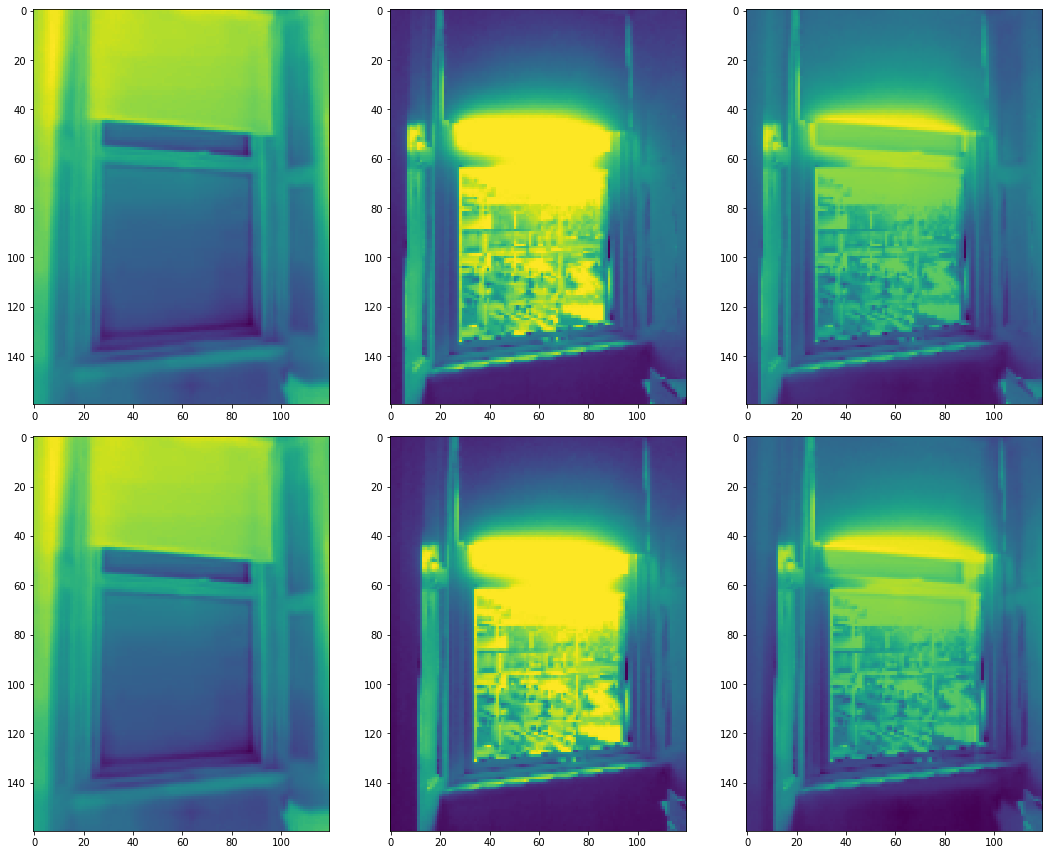

In [401]:
f = "SE"
rgb_trans = cv2.warpAffine(rgb, trans, (fir.shape[1], fir.shape[0]))
rgb_res = cv2.warpAffine(rgb, res, (fir.shape[1], fir.shape[0]))

fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 12))
fig.tight_layout()

# ax1.imshow(preprocess(fir, f))
# ax3.imshow(preprocess(fir, f))

# ax2.imshow(preprocess(rgb, f))
# ax4.imshow(preprocess(rgb_trans, f))

ax1.imshow(fir)
ax4.imshow(fir)

ax2.imshow(rgb_trans)
ax5.imshow(rgb_res)

ax3.imshow((rgb_trans * 0.02 + fir) / 2)
ax6.imshow((rgb_res * 0.02 + fir) / 2)